In [ ]:
#Reference: repo from @mickinhere and @Chili 
#STEP1: Setting Up 

!pip install moviepy
!pip install pytube

import torch
import os
from pytube import YouTube

import tensorflow as tf
import os

def download_model(model_type):
    server_prefix = 'https://omnomnom.vision.rwth-aachen.de/data/metrabs'
    model_zippath = tf.keras.utils.get_file(
        origin=f'{server_prefix}/{model_type}_20211019.zip',
        extract=True, cache_subdir='models')
    model_path = os.path.join(os.path.dirname(model_zippath), model_type)
    return model_path

model = tf.saved_model.load(download_model('metrabs_mob3l_y4t')) # or metrabs_eff2l_y4 for the big model
! wget -q https://raw.githubusercontent.com/isarandi/metrabs/master/img/test_image_3dpw.jpg
image = tf.image.decode_jpeg(tf.io.read_file('test_image_3dpw.jpg'))



%cd /content
folder_name = 'video'
# Create the folder
os.makedirs(folder_name, exist_ok=True)


import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from mpl_toolkits.mplot3d import Axes3D

def visualize(im, detections, poses3d, poses2d, edges):
    fig = plt.figure(figsize=(10, 5.2))
    image_ax = fig.add_subplot(1, 2, 1)
    image_ax.imshow(image)
    for x, y, w, h in detections[:, :4]:
        image_ax.add_patch(Rectangle((x, y), w, h, fill=False))

    pose_ax = fig.add_subplot(1, 2, 2, projection='3d')
    pose_ax.view_init(5, -85)
    pose_ax.set_xlim3d(-1500, 1500)
    pose_ax.set_zlim3d(-1500, 1500)
    pose_ax.set_ylim3d(0, 3000)

    # Matplotlib plots the Z axis as vertical, but our poses have Y as the vertical axis.
    # Therefore, we do a 90° rotation around the X axis:
    poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
    for pose3d, pose2d in zip(poses3d, poses2d):
        #print(pose3d.shape)
        #print(pose2d.shape)
        for i_start, i_end in edges:
            image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)
            pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
        image_ax.scatter(*pose2d.T, s=2)
        pose_ax.scatter(*pose3d.T, s=2)

    fig.tight_layout()
    plt.show()





     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.6/57.6 kB 1.2 MB/s eta 0:00:00
41976188/41976188 [==============================] - 3s 0us/step
/content


In [ ]:
#STEP2: Setting up a Youtube URL
# Specify the video URL

video_url = 'https://www.youtube.com/watch?v=CHHjc-Rw62w'

# Create a YouTube object with the URL
yt = YouTube(video_url)

# Get the highest resolution stream available
stream = yt.streams.get_highest_resolution()

# Download the video
stream.download(output_path='/content/video')
directory_path = '/content/video'

file_list=[]
# List all files and directories in the specified path
for entry in os.listdir(directory_path):
    full_path = os.path.join(directory_path, entry)
    if os.path.isfile(full_path):
        #print(full_path)
        file_list.append(full_path)
print(file_list)

# Specify the path to the downloaded video
video_path = file_list[0]
working_video=video_path

print('Download completed!')

['/content/video/Dua Lipa - Cold Heart - Live (Paris 15052022) Accor Arena 4K.mp4']
Download completed!


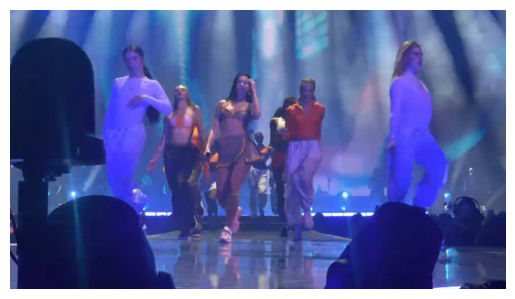

In [ ]:
#STEP3: One Frame Test
from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt

# Load the video file
video_path
video = VideoFileClip(video_path)

# Time of the frame to extract (in seconds)
time = 12

# Extract the frame
frame = video.get_frame(time)

# Display the frame using matplotlib
plt.imshow(frame)
plt.axis('off')  # Turn off axis numbers and ticks
plt.show()

# Optionally, save the frame as an image
frame_image_path = 'frame_at_12_seconds.jpg'
plt.imsave(frame_image_path, frame)


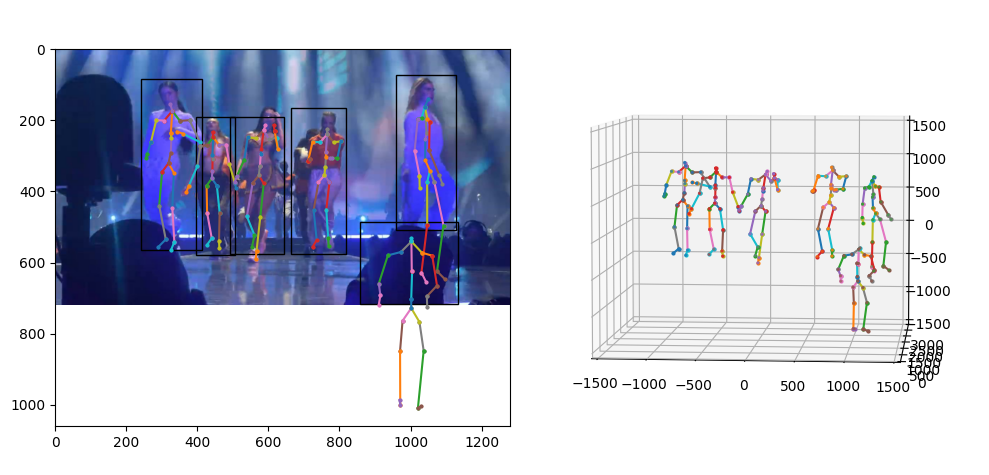

In [ ]:
#STEP4: POSE ESTIMATION (one frame test)

image_path= '/content/frame_at_12_seconds.jpg'
image = tf.image.decode_jpeg(tf.io.read_file(image_path))
pred = model.detect_poses(image, skeleton='smpl_24')

visualize(
    image.numpy(),
    pred['boxes'].numpy(),
    pred['poses3d'].numpy(),
    pred['poses2d'].numpy(),
    model.per_skeleton_joint_edges['smpl_24'].numpy())


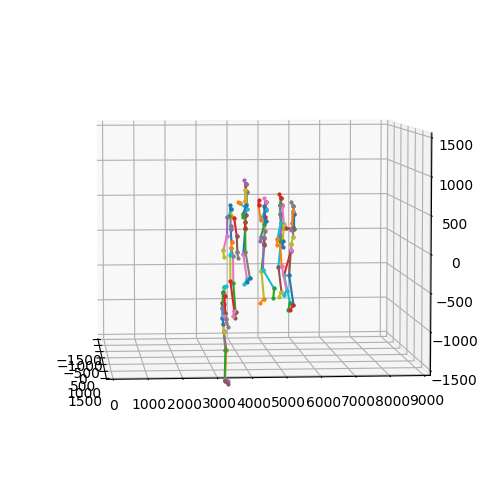

(6, 23, 2, 3)
(6, 23, 2, 3)
[-1109.5985, 4470.1616, 47.160217, -1108.3134, 4410.1396, -304.58725, -1109.5985, 4470.1616, 47.160217, -1169.0707, 4487.8955, 146.32526, -1238.9694, 4501.8853, 56.69699, -1273.0698, 4521.5234, -291.52823, -1238.9694, 4501.8853, 56.69699, -1169.0707, 4487.8955, 146.32526, -1152.1862, 4510.3174, 253.24358, -1145.1096, 4506.001, 400.23224, -1152.1862, 4510.3174, 253.24358, -1169.0707, 4487.8955, 146.32526, -1108.3134, 4410.1396, -304.58725, -1118.1135, 4533.057, -664.96094, -1273.0698, 4521.5234, -291.52823, -1239.4689, 4652.8857, -657.55096, -1145.1096, 4506.001, 400.23224, -1144.9336, 4481.8345, 451.8226, -1118.1135, 4533.057, -664.96094, -1128.9606, 4441.746, -735.40173, -1239.4689, 4652.8857, -657.55096, -1295.9874, 4584.3174, -724.0912, -1144.9336, 4481.8345, 451.8226, -1133.6952, 4494.79, 681.93567, -1133.6952, 4494.79, 681.93567, -1054.5978, 4491.857, 579.8021, -1133.6952, 4494.79, 681.93567, -1220.0891, 4510.5635, 584.3483, -1133.6952, 4494.79, 681.935

In [ ]:
#STEP5: Output Skeleton Data for Grasshopper

import numpy as np

def skeleton_3d(im, detections, poses3d, poses2d, edges):

    fig = plt.figure(figsize=(10, 5.2))
    """
    image_ax = fig.add_subplot(1, 2, 1)
    image_ax.imshow(image)
    for x, y, w, h in detections[:, :4]:
        image_ax.add_patch(Rectangle((x, y), w, h, fill=False))
    """
    pose_ax = fig.add_subplot(1, 2, 2, projection='3d')
    pose_ax.view_init(5, -5)
    pose_ax.set_xlim3d(-1500, 1500)
    pose_ax.set_zlim3d(-1500, 1500)
    pose_ax.set_ylim3d(0, 9000)

    # Matplotlib plots the Z axis as vertical, but our poses have Y as the vertical axis.
    # Therefore, we do a 90° rotation around the X axis:
    poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
    skeletons=[]
    for pose3d, pose2d in zip(poses3d, poses2d):
        #print(pose3d.shape)
        #print( pose3d)
        #print(pose2d.shape)
        one_skeleton=[]
        for i_start, i_end in edges:
            #image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)
            pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
            skeleton=np.array([pose3d[i_start], pose3d[i_end]])
            #print( skeleton )
            one_skeleton.append(skeleton)
        skeletons.append(one_skeleton)
        #image_ax.scatter(*pose2d.T, s=2)
        #pose_ax.scatter(*pose3d.T, s=2)

    fig.tight_layout()
    plt.show()
    return np.array(skeletons)

result=skeleton_3d(
    image.numpy(),
    pred['boxes'].numpy(),
    pred['poses3d'].numpy(),
    pred['poses2d'].numpy(),
    model.per_skeleton_joint_edges['smpl_24'].numpy())

print(result.shape)

np.save("/content/skeletons",result.reshape(-1))

print(result.shape)
data=list(result.reshape(-1))
print(data)
st=str(data)[1:-1]
print(st)
file_name = "sample.csv"
# Open the file in write mode ('w') and write the string
with open(file_name, 'w') as file:
    file.write(st)

In [ ]:
#STEP6: Multiple Frames Processing

#video_path = 'your_video.mp4'  # Replace with your video file path
start_time = 1  # Start at 1 second
end_time = 5    # End at 3 seconds
num_frames = 100  # Number of frames to extract
output_dir = '/content/extracted_frames_jpg'  # Directory to save the frames



from moviepy.editor import VideoFileClip
import matplotlib.pyplot as plt
import os
import numpy as np

def extract_and_save_frames(video_path, start_time, end_time, num_frames, output_dir):
    # Ensure the output directory exists
    os.makedirs(output_dir, exist_ok=True)

    # Load the video file
    video = VideoFileClip(video_path)

    # Calculate the interval between each frame to extract
    interval = (end_time - start_time) / num_frames

    # Extract and save each frame
    for i in range(num_frames):
        # Calculate the time for the current frame
        time = start_time + i * interval

        # Extract the frame
        frame = video.get_frame(time)

        # Frame image path
        frame_image_path = os.path.join(output_dir, f'{time:.2f}.jpg')

        # Save the frame as an image
        plt.imsave(frame_image_path, frame)

        print(f"Saved: {frame_image_path}")

# Example usage


extract_and_save_frames(video_path, start_time, end_time, num_frames, output_dir)

dir_path = '/content/csv_output/'

# Create the directory if it doesn't exist
if not os.path.exists(dir_path):
    os.makedirs(dir_path)
    print(f"Directory '{dir_path}' created")
else:
    print(f"Directory '{dir_path}' already exists")

def list_files(directory):
    # List all files and directories in 'directory'
    entries = os.listdir(directory)
    # Full paths of files
    files = [os.path.join(directory, entry) for entry in entries if os.path.isfile(os.path.join(directory, entry))]

    return files

directory = output_dir  # Replace with your directory path
files = list_files(directory)


def skeleton_3d(im, detections, poses3d, poses2d, edges):
    #fig = plt.figure(figsize=(10, 5.2))
    #image_ax = fig.add_subplot(1, 2, 1)
    #image_ax.imshow(image)

    # Matplotlib plots the Z axis as vertical, but our poses have Y as the vertical axis.
    # Therefore, we do a 90° rotation around the X axis:
    poses3d[..., 1], poses3d[..., 2] = poses3d[..., 2], -poses3d[..., 1]
    output_data=[]
    for pose3d, pose2d in zip(poses3d, poses2d):
        #print(pose3d.shape)
        #print(pose2d.shape)
        #print(output_data)
        for i_start, i_end in edges:
          output_data.append([pose3d[i_start], pose3d[i_end]])


            #image_ax.plot(*zip(pose2d[i_start], pose2d[i_end]), marker='o', markersize=2)
            #pose_ax.plot(*zip(pose3d[i_start], pose3d[i_end]), marker='o', markersize=2)
        #image_ax.scatter(*pose2d.T, s=2)
        #pose_ax.scatter(*pose3d.T, s=2)

    return np.array(output_data)

for file in files:
    print(file)
    image_path= file
    image = tf.image.decode_jpeg(tf.io.read_file(image_path))
    pred = model.detect_poses(image, skeleton='smpl_24')

    result=skeleton_3d(
      image.numpy(),
      pred['boxes'].numpy(),
      pred['poses3d'].numpy(),
      pred['poses2d'].numpy(),
      model.per_skeleton_joint_edges['smpl_24'].numpy())


    data=result.reshape(-1,23,2,3)
    print(data.shape)
    st=str(list(data.reshape(-1)))[1:-1]
    d_n=image_path.split('/')[-1].replace(image_path.split('/')[-1].split('.')[-1],'csv')
    file_name = "/content/csv_output/"+d_n
    # Open the file in write mode ('w') and write the string
    with open(file_name, 'w') as file:
      file.write(st)







Saved: /content/extracted_frames_jpg/1.00.jpg
Saved: /content/extracted_frames_jpg/1.04.jpg
Saved: /content/extracted_frames_jpg/1.08.jpg
Saved: /content/extracted_frames_jpg/1.12.jpg
Saved: /content/extracted_frames_jpg/1.16.jpg
Saved: /content/extracted_frames_jpg/1.20.jpg
Saved: /content/extracted_frames_jpg/1.24.jpg
Saved: /content/extracted_frames_jpg/1.28.jpg
Saved: /content/extracted_frames_jpg/1.32.jpg
Saved: /content/extracted_frames_jpg/1.36.jpg
Saved: /content/extracted_frames_jpg/1.40.jpg
Saved: /content/extracted_frames_jpg/1.44.jpg
Saved: /content/extracted_frames_jpg/1.48.jpg
Saved: /content/extracted_frames_jpg/1.52.jpg
Saved: /content/extracted_frames_jpg/1.56.jpg
Saved: /content/extracted_frames_jpg/1.60.jpg
Saved: /content/extracted_frames_jpg/1.64.jpg
Saved: /content/extracted_frames_jpg/1.68.jpg
Saved: /content/extracted_frames_jpg/1.72.jpg
Saved: /content/extracted_frames_jpg/1.76.jpg
Saved: /content/extracted_frames_jpg/1.80.jpg
Saved: /content/extracted_frames_j

In [ ]:
#STEP7: Download Skeleton Data
import os
import shutil
from google.colab import files

folder_path= '/content/csv_output'
# Step 2: Zip the folder
zip_path = '/content/csv_output.zip'
shutil.make_archive(base_name=zip_path.replace('.zip', ''), format='zip', root_dir=folder_path)

# Step 3: Download the zip file
files.download(zip_path)



<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
#STEP8: Download Grasshopper Definition for Visualizing Skeletons
!pip install gdown
import gdown

url = 'https://drive.google.com/uc?id=1XDyw8T3556kCh0k_Fp0QdE4QM6QCDR95'
output = 'skeleton.gh' # Provide the desired file name and extension
gdown.download(url, output, quiet=False)
from google.colab import files
# Use the same file name as when you saved/downloaded it in Colab
file_name = '/content/skeleton.gh'
files.download(file_name)


Downloading...
From: https://drive.google.com/uc?id=1XDyw8T3556kCh0k_Fp0QdE4QM6QCDR95
To: /content/skeleton.gh
100%|██████████| 7.65k/7.65k [00:00<00:00, 21.4MB/s]


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>